# 2.6 - Data analysis and modeling Pt. II

### Learning goals for today
1. Learn to use visualization tools for large datasets
2. Use scipy to perform hypothesis testing
3. Use scikit-learn to build, train, and test machine learning models for classification

---
### How to use this notebook during class
- Follow along as we go
- Use your **Cards** to indicate where you're at:
    - A **🟩Green card** means you are caught up with Max and **ready to help your classmates**
    - A **🟥Red card** means you are stuck and need help
- <span style='color:red;'>EXERCISE</span> — work on this problem by yourself, or try with a partner if you get stuck
---


First let's import some libraries we will use today. Remember if you don't have a library installed you can pip install it with:

%pip install *package_name*

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

## 1) Visualizing lots of data

This data is originally from Peter & Rosemary Grant's book on Darwin's finches: https://search.worldcat.org/title/854285415

And I got it from Justin Bois' great programming for biological sciences bootcamp: 
https://github.com/justinbois/bootcamp



In [9]:
beak_df = pd.read_csv('grant_complete.csv')
beak_df.head()

,band,beak depth (mm),beak length (mm),species,year
0,20123,8.05,9.25,fortis,1973
1,20126,10.45,11.35,fortis,1973
2,20128,9.55,10.15,fortis,1973
3,20129,8.75,9.95,fortis,1973
4,20133,10.15,11.55,fortis,1973


Let's just pull out a subset of the data that we are interested in: for example, data from **fortis** in the year **2012**

There are (at least) two ways to do this, the first is the one we have used already:
1. The **query()** function
2. **.loc boolean indexing**

Let's see how each of these works

In [12]:
beak_df.query('species == "fortis" and year == 2012')

,band,beak depth (mm),beak length (mm),species,year
2052,19022,8.5,10.0,fortis,2012
2053,19028,8.9,12.5,fortis,2012
2054,19032,7.5,9.3,fortis,2012
2055,19041,9.6,10.3,fortis,2012
2056,19044,9.2,11.0,fortis,2012
...,...,...,...,...,...
2168,21299,7.8,10.4,fortis,2012
2169,21341,8.5,10.5,fortis,2012
2170,21343,8.2,10.1,fortis,2012
2171,21349,9.2,10.6,fortis,2012


In [13]:
beak_df.loc[(beak_df['species']=="fortis") & (beak_df['year']==2012)]

,band,beak depth (mm),beak length (mm),species,year
2052,19022,8.5,10.0,fortis,2012
2053,19028,8.9,12.5,fortis,2012
2054,19032,7.5,9.3,fortis,2012
2055,19041,9.6,10.3,fortis,2012
2056,19044,9.2,11.0,fortis,2012
...,...,...,...,...,...
2168,21299,7.8,10.4,fortis,2012
2169,21341,8.5,10.5,fortis,2012
2170,21343,8.2,10.1,fortis,2012
2171,21349,9.2,10.6,fortis,2012


### <span style='color:red;'>EXERCISE 1</span>: Compute descriptive statistics  (10 min)

Compute the mean beak length and depth for each species. There are at least two ways to do it...



In [20]:
fortis_length = beak_df.loc[(beak_df['species']=="fortis")]['beak depth (mm)'].mean()
print(fortis_length)


9.23398446170921


In [21]:
beak_df.groupby('species').agg('mean')['beak length (mm)']

species
fortis      10.810766
scandens    13.941751
Name: beak length (mm), dtype: float64

### Visualizing beak size data
Let's see if we can see a difference between these species using a scatter plot

<Axes: xlabel='beak length (mm)', ylabel='beak depth (mm)'>

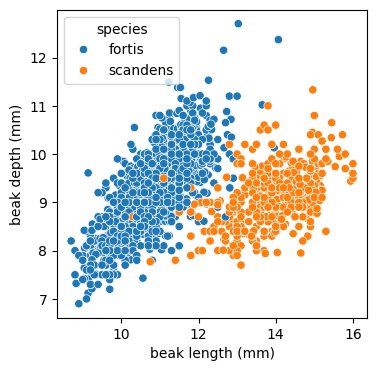

In [23]:
fh, ax = plt.subplots (1, 1, figsize=(4,4))
sns.scatterplot(data=beak_df,
                x='beak length (mm)',
                y='beak depth (mm)',
                hue='species',
                ax=ax)

There are lots of datapoints here, so let's try to visualize the distributions a bit better using a **jointplot**, which shows the points as well as marginal distributions on the sides

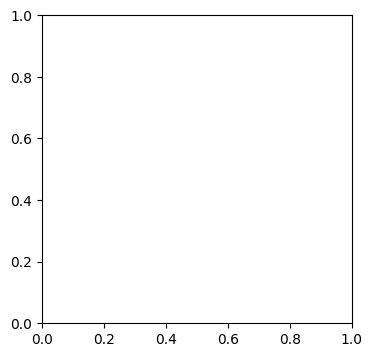

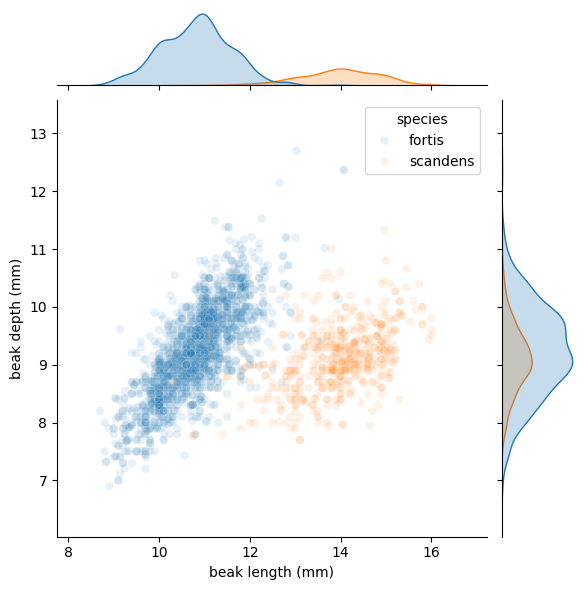

In [24]:
fh, ax = plt.subplots (1, 1, figsize=(4,4))
sns.jointplot(data=beak_df,
                x='beak length (mm)',
                y='beak depth (mm)',
                hue='species',
                kind ='scatter',
                alpha=0.1)

### <span style='color:red;'>EXERCISE 2</span>: Test the hypothesis that scandens has a longer beak than fortis (10 min)
Use scipy.stats.mannwhitneyu() to perform a hypothesis test to compare beak lenght between the two species

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

*Hint:
It will be cleaner to first assign new variables for the two groups you are comparing, call them

`beak_len_fortis`

`beak_len_scandens`


In [27]:
beak_len_fortis = beak_df.query('species=="fortis" ')
beak_len_scandens = beak_df.query('species=="scandens" ')
fortis = beak_len_fortis.



In [30]:
beak_len_fortis = beak_df.query('species=="fortis"')['beak length (mm)']
beak_len_scandens = beak_df.query('species=="scandens"')['beak length (mm)']

statistic, p = stats.mannwhitneyu(x=beak_len_fortis,
                                  y=beak_len_scandens)
print(statistic,p)

8809.0 3.5160059993134826e-246


## 2) Machine learning classification

The beak size distributions are pretty non-overlapping, which suggests that we should be able to predict the species based on beak measurements alone. One way to do this is with a classifier model.

We are going to use a simple, commmon model called a **Support Vector Machine (SVM)**.

let's install / import the python machine learning library scikit-learn

%pip install scikit-learn


sklearn has an implementation of an SVM for classification called a **Support Vector Classifier (SVC)**



### Getting the data ready
we need a features matrix, (by convention we'll call it X), which is shape = (n_samples, n_features), for us n_features will be 2
and a values matrix (y), which will be length n_samples and just be the species name for each sample

The steps for doing this kind of classification are:
1. Split the data into training data and testing data
2. Fit the model
3. Predict some testing data and evaluate the model's performance

### Visualizing the decision boundary
SVM works by forming a decision boundary in the feature space that splits points into each class. In this case the feature space is just two dimensional, so it's easy to visualize. But in principle this can be a high dimensional feature space